In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read in dataset and examine its attributes
fer_dataset = pd.read_csv('fer2013/fer2013.csv')
fer_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [7]:
# Drop the usage column because we don't need it
fer_dataset.drop(['Usage'], axis=1, inplace=True)

In [9]:
# Map the emotion integer encoding to labels 
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
emotion_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}


In [21]:
print(type(fer_dataset['pixels'].iloc[0]))

<class 'str'>


In [23]:
# Convert pixel strings to numpy arrays
fer_dataset['pixels'] = fer_dataset['pixels'].apply(lambda img: np.array(img.split(' ')).reshape(48, 48).astype('float32'))

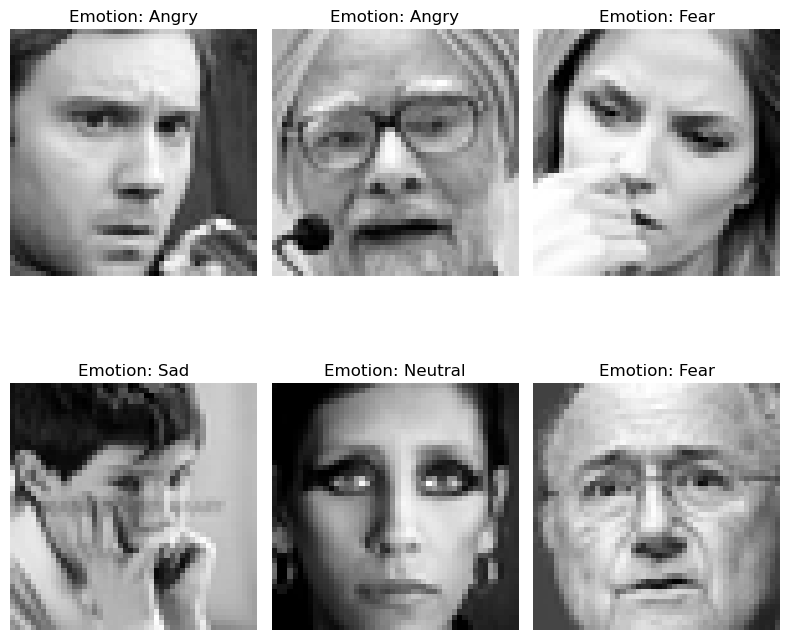

In [34]:
# Display the first 6 images in grayscale
fig = plt.figure(figsize=(8,8))
for i in range(6):
    img = fer_dataset['pixels'].iloc[i]
    emotion = emotion_mapping[fer_dataset['emotion'].iloc[i]]
    plt.subplot(2,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Emotion: {emotion}")
    plt.axis('off')

fig.tight_layout()
plt.show()